In [199]:
#adapted from: Nancy Cui, Classification.ipynb

from os.path import abspath, dirname
import pandas as pd
import numpy as np
import obonet
import networkx as nx
from pyensembl import EnsemblRelease

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve, average_precision_score

from collections import Counter

def save_gsms(metadata_table):
    gsms=metadata_table['sample_id']
    gsms.to_csv('./../annotation/gsms.csv',index=False, header=False)
    print(f"number of gsms: {len(gsms)}")

In [2]:
beta_value = pd.read_csv('./../data/all_betavalues_2.txt', sep='\t')
metadata=pd.read_csv('./../data/GEO_metadata_test2.txt',sep='\t')
tissue_ontology_tree=obonet.read_obo('./../annotation/bto.obo')

In [3]:
print(beta_value.shape)
print(metadata.shape)

(452263, 4184)
(3560, 3)


In [5]:
#remove X and Y chromosomes
beta_value_all=beta_value
index_names1=beta_value[beta_value['V1']=='chrX'].index
index_names2=beta_value[beta_value['V1']=='chrY'].index
index_names=index_names1.append(index_names2)
beta_value.drop(index_names, inplace=True)
beta_value.reset_index(drop=True)

#label features as: [chr# position]
empty=[' ']*len(beta_value)
feature=np.char.array(beta_value['V1'])+np.char.array(empty)
feature=pd.DataFrame(np.char.array(feature)+np.char.array(list(map(str, beta_value['V2']))))
feature.index=beta_value.index

In [9]:
#Get samples with both methylation data and metadata annotation
beta_samples=list(beta_value.columns)[2:]
metadata_samples=metadata['sample_id']
both_beta_metadata=set(beta_samples).intersection(metadata_samples)

#Remove overlapping samples
index_to_delete=['GSM3813550', 'GSM3813542', 'GSM3813555', 'GSM3813541', 'GSM3813540']
for i in index_to_delete:
    if i in both_beta_metadata: both_beta_metadata.remove(i)

In [11]:
#filter for those with beta values and metadata info
beta_value=beta_value[both_beta_metadata]
metadata=metadata[metadata['sample_id'].isin(both_beta_metadata)]

normal_mask=metadata['disease_name']=='normal'
normal_beta=beta_value[beta_value.columns[normal_mask]]
normal_meta=metadata[normal_mask]
normal_tissue_term=normal_meta['tissue_name']

print(normal_beta.shape)
print(normal_meta.shape)
print(len(normal_tissue_term))

#exclude mislabeled tissues
avoid=['embryonic stem cell line','MDA-MB-436 cell','NCI-H1299 cell','breast cancer','colorectal cancer cell']
normal_sample_index=[i for i in range(0,len(normal_tissue_term)) \
                     if (normal_tissue_term.iloc[i] not in avoid)]
normal_sample_value=normal_tissue_term.iloc[normal_sample_index]
print(len(normal_sample_index))
print(len(normal_sample_value))
print(np.unique(normal_sample_value))

normal_beta=normal_beta.iloc[:,normal_sample_index]
normal_meta=normal_meta.iloc[normal_sample_index]
print(normal_beta.shape)
print(normal_meta.shape)

(441694, 2480)
(2480, 3)
2480
2438
2438
['adrenal gland' 'blood' 'bronchoalveolar lavage fluid' 'buccal mucosa'
 'colon' 'colorectum' 'liver' 'memory T-lymphocyte' 'monocyte'
 'naive T-lymphocyte' 'pancreas' 'peripheral blood'
 'peripheral blood mononuclear cell' 'saliva' 'skin' 'skin fibroblast'
 'thyroid gland' 'umbilical cord blood' 'vastus lateralis']
(441694, 2438)
(2438, 3)


In [12]:
print(beta_value.shape)
print(metadata.shape)
print(feature.shape)

(441694, 3555)
(3555, 3)
(441694, 1)


In [13]:
#dictionary of names to id from brenda
id_to_name = {id_:data.get('name') for id_, data in tissue_ontology_tree.nodes(data=True)}
name_to_id = {data.get('name'):id_ for id_, data in tissue_ontology_tree.nodes(data=True)}

In [36]:
# Get the correponding nodes of all metadata (selected_nodes) 
# and all the nodes that connect them into a DAG (completed nodes)
def create_subgraph(tissue_ontology_tree,normal_sample_value):
    selected_nodes=list(name_to_id[x] for x in list(set(normal_sample_value)))
    completed_nodes=[]
    for node_element in selected_nodes:
#         print(node_element)
        completed_nodes=completed_nodes+list(nx.ancestors(tissue_ontology_tree,node_element))
    completed_nodes=completed_nodes+selected_nodes
    return(completed_nodes)

completed_nodes=create_subgraph(tissue_ontology_tree,normal_sample_value)

In [37]:
# Create subgraph containing all completed nodes (DAG)
tissue_subgraph=tissue_ontology_tree.subgraph(completed_nodes)
# display(nx.draw(tissue_subgraph,pos=nx.circular_layout(tissue_subgraph, scale=5),with_labels=True,font_size=8))
# print(list(id_to_name[i] for i in list(tissue_subgraph.nodes())))
# print(nx.is_weakly_connected(tissue_subgraph))
print(len(completed_nodes))
print(len(tissue_subgraph.nodes))

1661
1422


In [38]:
#GRCh38
#gene at locus, exon ids, etc 
data = EnsemblRelease(77)

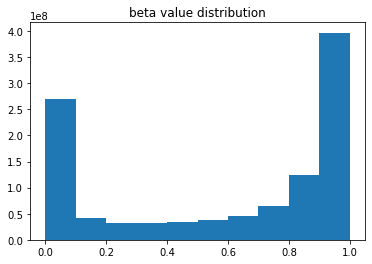

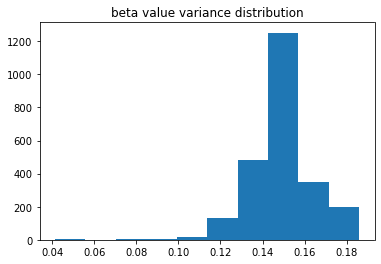

In [39]:
#filter for normal
normal_tissue_term=normal_meta['tissue_name']

#check beta-value distribution
plt.hist(np.array(normal_beta.values).flatten(), range=(0,1))
plt.title('beta value distribution')
plt.show()
plt.hist(np.array(normal_beta.values).var(0))
plt.title('beta value variance distribution')
plt.show()

In [40]:
#filter by variance and get mask
selector=VarianceThreshold(threshold=(0.15))
filtered_beta=pd.DataFrame(selector.fit_transform(normal_beta.T.values), index=normal_beta.columns)
mask=selector.get_support(indices=True)
#     print(mask)

#filtered [chr# position] with mask
filtered_feature=feature.iloc[mask,]
#     print(filtered_feature)

In [41]:
print(filtered_beta.shape)
print(normal_meta.shape)
print(len(normal_tissue_term))
print(filtered_feature.shape)

(2438, 65333)
(2438, 3)
2438
(65333, 1)


In [47]:
# Create binary classifier Y values 
def get_indicator_matrix(node):
    id_node=name_to_id[node]
#     print(id_node)
    descendant_nodes=[i for i in range(filtered_beta.shape[0]) \
                    if name_to_id[normal_tissue_term.iloc[i]] in nx.descendants(tissue_ontology_tree, id_node)]
#     print(ancestor_nodes)
#     positive_sample_index=[i for i in normal_sample_index \
#                            if 
#                            (name_to_id[tissue_term.iloc[i]] \
#                             not in nx.descendants(tissue_ontology_tree, id_node)) \
#                            and \
#                            (name_to_id[tissue_term.iloc[i]] in \
#                             nx.ancestors(tissue_ontology_tree, id_node) \
#                             or name_to_id[tissue_term.iloc[i]]==id_node)]

    
#positive considered as node + node ancestors    
    positive_sample_index=[i for i in range(filtered_beta.shape[0]) \
                           if 
                           name_to_id[normal_tissue_term.iloc[i]] in nx.ancestors(tissue_ontology_tree, id_node)\
                           or 
                           name_to_id[normal_tissue_term.iloc[i]]==id_node
                          ]
    

    y_matrix=np.zeros(((len(normal_tissue_term)), 1))
    y_matrix[positive_sample_index]=1
#     print(filtered_beta.index)
#     samples_keep=list(set(filtered_beta.index)-set(ancestor_nodes))
    if bool(descendant_nodes):
        print("ancestor_nodes present")
        y_matrix_sample=np.delete(y_matrix, descendant_nodes)
        print(len(y_matrix))
        print(len(y_matrix_sample))
    else:
        y_matrix_sample=y_matrix
    return(y_matrix_sample,descendant_nodes,positive_sample_index)

[x,y,z]=get_indicator_matrix('adrenal gland')

In [54]:
filtered_feature_reset=filtered_feature.reset_index()[0]

In [55]:
all_genes=dict()
results=pd.DataFrame()

for i in set(normal_sample_value):
    print(i)
    [y_matrix_single, descendant_nodes, positive_sample]=get_indicator_matrix(i)
#     print(y_matrix_single.shape)
    
    #beta values of relevant nodes (normal samples without ancestor nodes)
#     filtered_nodes=list(set(filtered_beta.index)-set(ancestor_nodes))
    x_matrix_single=filtered_beta.drop(filtered_beta.index[descendant_nodes])
    print(x_matrix_single.shape)
    print(y_matrix_single.shape)

#     #filter by variance and get mask
#     selector=VarianceThreshold(threshold=(0.15))
#     filtered_X=selector.fit_transform(value_X)
#     mask=selector.get_support(indices=True)
# #     print(mask)

#     #filtered [chr# position] with mask
#     filtered_feature=list(feature[mask])
# #     print(filtered_feature)
    
    #split train/test
    X_train,X_test,y_train,y_test=train_test_split(x_matrix_single, y_matrix_single, 
                                                   stratify= y_matrix_single,
                                                   test_size=0.20, random_state=42) 
    
    #one vs rest linear svm accuracy
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
    print("Accuracy:",clf.score(X_test, y_test))
    
    filtered_feature_list=list(filtered_feature.values)
    
    #decision function coeff
    coefficients=list(clf.coef_[0,:])
    coeffdict={coefficients[i]:filtered_feature_reset.iloc[i] for i in range(0, len(coefficients))}
    coordinate_coeffdict={coefficients[i]:mask[i] for i in range(0, len(coefficients))}
    sorted_coeffs=sorted(coefficients, key=abs, reverse=True)
    CpGcoord20=[coordinate_coeffdict[key] for key in sorted_coeffs[0:20]]
    gene_names=[]
    gene_ids=[]
    for j in CpGcoord20:
        chromo=filtered_feature.loc[j].values[0].split('chr')[1].split(' ')[0]
        CpGposition=filtered_feature.loc[j].values[0].split('chr')[1].split(' ')[1]
        gene_names.append(data.gene_names_at_locus(contig=chromo, position=int(CpGposition)))
        gene_ids.append(data.gene_ids_at_locus(contig=chromo, position=int(CpGposition)))
        
    all_genes.update({i:gene_names})
#     print(gene_names)
#     print(gene_ids)

    #print 20 top decision function coeffs
#     fig = plt.figure()
#     ax = fig.add_axes([0,0,1,1])
#     ax.bar([coeffdict[key] for key in sorted_coeffs[0:20]],sorted_coeffs[0:20])
#     plt.xticks(rotation=90)
#     plt.show()
#     y_prob=clf.predict_proba(X_test)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    #auc
    fpr, tpr, _ = roc_curve(y_test, y_score)
    print('AUC:'+str(auc(fpr,tpr)))
#     plot_roc_curve(clf, X_test, y_test)
#     plt.show()
    
    results.loc['auc', i]=auc(fpr, tpr)
    results.loc['accuracy', i]=clf.score(X_test, y_test)
#     print(results)
    
#     print()

print(results.T)

bronchoalveolar lavage fluid
(2438, 65333)
(2438, 1)
Accuracy: 0.9754098360655737


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.4391092553931802
vastus lateralis
(2438, 65333)
(2438, 1)
Accuracy: 0.9569672131147541


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.42412605932203395
monocyte
ancestor_nodes present
2438
1309
(1309, 65333)
(1309,)
Accuracy: 0.9961832061068703


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.3831417624521073
pancreas
(2438, 65333)
(2438, 1)
Accuracy: 0.9959016393442623


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.6882716049382717
skin
(2438, 65333)
(2438, 1)
Accuracy: 0.9918032786885246


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.571797520661157
peripheral blood mononuclear cell
ancestor_nodes present
2438
1275
(1275, 65333)
(1275,)
Accuracy: 0.807843137254902


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.5224358974358975
adrenal gland
(2438, 65333)
(2438, 1)
Accuracy: 0.9959016393442623


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.5524691358024691
saliva
(2438, 65333)
(2438, 1)
Accuracy: 0.9528688524590164


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.49594017094017095
buccal mucosa
(2438, 65333)
(2438, 1)
Accuracy: 0.9713114754098361


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.5682008368200837
colon
ancestor_nodes present
2438
2418
(2418, 65333)
(2418,)
Accuracy: 0.9958677685950413


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.4450207468879668
naive T-lymphocyte
ancestor_nodes present
2438
1309
(1309, 65333)
(1309,)
Accuracy: 0.9961832061068703


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.24904214559386972
peripheral blood
ancestor_nodes present
2438
1309
(1309, 65333)
(1309,)
Accuracy: 0.767175572519084


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.5039251207729469
skin fibroblast
ancestor_nodes present
2438
2422
(2422, 65333)
(2422,)
Accuracy: 0.9979381443298969


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.030991735537190035
umbilical cord blood
ancestor_nodes present
2438
1309
(1309, 65333)
(1309,)
Accuracy: 0.48091603053435117


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.48328658251519396
liver
(2438, 65333)
(2438, 1)
Accuracy: 0.9897540983606558


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.317184265010352
thyroid gland
(2438, 65333)
(2438, 1)
Accuracy: 0.9979508196721312


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.16632443531827512
colorectum
(2438, 65333)
(2438, 1)
Accuracy: 0.9836065573770492


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.4533195020746888
blood
(2438, 65333)
(2438, 1)
Accuracy: 0.7868852459016393


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.4622437449556094
memory T-lymphocyte
ancestor_nodes present
2438
1309
(1309, 65333)
(1309,)
Accuracy: 0.9961832061068703


/opt/conda/envs/methyl/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


AUC:0.11877394636015326
                                        auc  accuracy
bronchoalveolar lavage fluid       0.439109  0.975410
vastus lateralis                   0.424126  0.956967
monocyte                           0.383142  0.996183
pancreas                           0.688272  0.995902
skin                               0.571798  0.991803
peripheral blood mononuclear cell  0.522436  0.807843
adrenal gland                      0.552469  0.995902
saliva                             0.495940  0.952869
buccal mucosa                      0.568201  0.971311
colon                              0.445021  0.995868
naive T-lymphocyte                 0.249042  0.996183
peripheral blood                   0.503925  0.767176
skin fibroblast                    0.030992  0.997938
umbilical cord blood               0.483287  0.480916
liver                              0.317184  0.989754
thyroid gland                      0.166324  0.997951
colorectum                         0.453320  0.983607
bloo

In [56]:
pd.DataFrame(all_genes)

,bronchoalveolar lavage fluid,vastus lateralis,monocyte,pancreas,skin,peripheral blood mononuclear cell,adrenal gland,saliva,buccal mucosa,colon,naive T-lymphocyte,peripheral blood,skin fibroblast,umbilical cord blood,liver,thyroid gland,colorectum,blood,memory T-lymphocyte
0,[ESR1],[],[],[RP11-529A4.12],[ARMC9],[MEIS1],[MEIS1],[],[DOHH],[HCK],[],[IPO9],[],[CREB3L1],[VTI1A],[],[],[],"[TRBC2, TRBV25-1, TRBV28]"
1,[],[AP000688.14],[ACTB],[NEAT1],[TNXB],[IPO9],[MT1A],[],[PLCG2],[],[STC1],[TEP1],[GPA33],[NFIA],[],[],[CDH18],[],[]
2,[VPS13C],[SOS2],[SOD3],[PHTF2],[],[INPP4A],[RP11-13A1.3],"[FBXL15, PSD]",[],[PTPRS],"[GNAI3, GNAT2]",[],[PFKP],[DOC2A],[],[KCNB1],[],[KRT8P24],[ERLIN1]
3,[SRBD1],"[PSMG4, SLC22A23]",[CMIP],[AC009784.3],[RNF217-AS1],[SEMA3B],[RBP7],[MANSC1],[ENPP2],"[AADACL2-AS1, SUCNR1]","[CDK2, PMEL, RP11-973D8.4]",[SDR39U1],"[CRIP3, SLC22A7]",[IPO9],"[LAD1, TNNT2]",[SLC39A10],[FAM91A1],[FLJ31356],[DGCR8]
4,[AGPAT1],[AGAP1],[ZBTB48],[TMEM18],[],[CREB3L1],[KCTD7],[],[TNXB],[SH3PXD2B],[RIIAD1],[BCAR3],[SLC35F4],[INTS6],[MGAT4C],[MYLK],[BAIAP2],[],[]
5,"[CITF22-24E5.1, PVALB]",[GRM4],[],[SCAMP4],[],[MYOZ3],[MTRR],[],"[RFKP1, RGS7]",[RP11-106M7.1],[SPG7],"[SBF2, SBF2-AS1]",[],[LMO1],[CCDC124],[],[OSBPL5],[ZNF287],[CTH]
6,[NLRP11],[],"[SBF2, SBF2-AS1]","[DPH5, RP11-421L21.3]",[PISD],[],[],[WDR91],[STRCP1],[],[DGCR8],[],[ERCC1],[],[],[GRIN2A],[],[LRPAP1],[RAD21L1]
7,[RP11-583F2.7],[SLC28A1],[HCAR1],[RP11-106M7.1],[RP11-72M17.1],[BCAR3],[KIF14],[SEMA6D],[],[CREB3L1],[],[MGMT],[CADPS2],[CALCOCO2],"[SBF2, SBF2-AS1]",[],[RCC2],[GRM4],"[SBF2, SBF2-AS1]"
8,[TRABD],[SHC2],[MAPRE2],[INTS6],"[PARP4, TPTE2P6]",[HIF1AN],[MICALL2],[KRT8P24],[],[ETFA],[DOC2A],[NBEAL2],[MCM6],[TSNARE1],"[DPH5, RP11-421L21.3]",[WWC2],[],[MAP3K9],[ZNF638]
9,[],[SLC35F4],[],[],[],"[SBF2, SBF2-AS1]","[C22orf23, MIR4534, POLR2F]",[SLU7],[MLC1],[IMPAD1],[AC009784.3],[CSF1],[],[KIF14],"[PCNXL3, SIPA1]",[TP73],[MGAT4C],[VWA2],[AGPAT1]


In [57]:
#save top genes per tissue in .csv
pd.DataFrame(all_genes).to_csv(path_or_buf='./../annotation/topgenes.csv',index=False)

In [58]:
#check if NA
check_na=filtered_beta.isna()
filtered_beta.columns[check_na.any()].tolist()

[]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


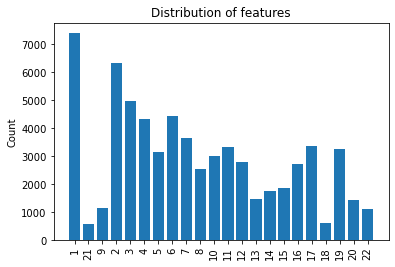

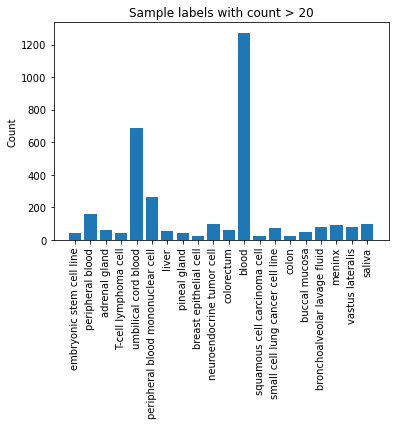

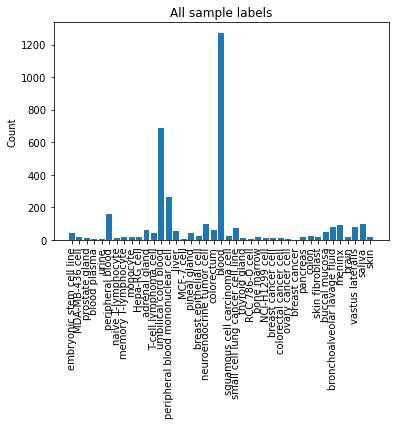

In [104]:
#feature distribution by chromosome
# feature_distribution=Counter(filtered_feature['V1'][mask])
feature_distribution=Counter([x[1] for x in filtered_feature[0].str.split(" |chr")])
plt.bar(list(dict(feature_distribution).keys()),list(dict(feature_distribution).values()))
# Add labels to your graph
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("Distribution of features")
plt.show()

metadata_index=[]
metadata_index_value=[]
for i in metadata['sample_id'].index:
    if (metadata['sample_id'][i] in both_beta_metadata) & \
    (metadata['sample_id'][i] not in metadata_index_value):
        metadata_index_value.append(metadata['sample_id'][i])
        metadata_index.append(i)
Y=metadata['tissue_name'][list(set(metadata_index))]

#condition distribution
Y_distribution=Counter(Y)
filtered_Y={key: value for key, value in Y_distribution.items() if value > 20}
plt.bar(list(dict(filtered_Y).keys()),list(dict(filtered_Y).values()))
# print(list(dict(filtered_Y).values()))
# Add labels to your graph
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("Sample labels with count > 20")
plt.show()

plt.bar(list(dict(Y_distribution).keys()),list(dict(Y_distribution).values()))
# print(list(dict(Y_distribution).values()))
# Add labels to your graph
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("All sample labels")
plt.show()

In [116]:
#save only the gsms in .txt
save_gsms(metadata)

#run src_sunny/get_gse.sh to get the gse that the gsms are from - check the gses.txt for result

number of gsms: 3555


In [10]:
#refer to gses.txt for tissues with samples from multiple studies
gses=pd.read_csv('./../annotation/gses.txt',sep='\t ', names=['gse'])
for col in ['sample_id','tissue_name','disease_name']:
    gses[col]=metadata[col]
gses

gses_empty=gses[gses['sample_id'].isna()]
gses=gses.drop(gses_empty.index)
gses

/opt/conda/envs/methyl/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


NameError: name 'metadata' is not defined

In [11]:
gses

,gse
0,GSM2722207\t GSE102031
1,GSM2722208\t GSE102031
2,GSM2722209\t GSE102031
3,GSM2722210\t GSE102031
4,GSM2722211\t GSE102031
...,...
3550,GSM4586455\t GSE151617
3551,GSM4586456\t GSE151617
3552,GSM4586457\t GSE151617
3553,GSM4586458\t GSE151617


In [165]:
for col in ['sample_id','tissue_name','disease_name']:
    gses[col]=metadata[col]
gses
mult_gse=list()
for tissue in np.unique(gses['tissue_name']):
    num_gse=len(np.unique(gses[gses['tissue_name']==tissue]['gse']))
    if num_gse>1:
        print(f"{tissue}: {num_gse}")
        mult_gse.append(tissue)
    
mult_gse

blood: 3
brain: 2
bronchoalveolar lavage fluid: 2
buccal mucosa: 2
colon: 2
embryonic stem cell line: 2
meninx: 2
pancreas: 2
peripheral blood: 4
peripheral blood mononuclear cell: 2
saliva: 2
skin fibroblast: 2
umbilical cord blood: 3
vastus lateralis: 2


['blood',
 'brain',
 'bronchoalveolar lavage fluid',
 'buccal mucosa',
 'colon',
 'embryonic stem cell line',
 'meninx',
 'pancreas',
 'peripheral blood',
 'peripheral blood mononuclear cell',
 'saliva',
 'skin fibroblast',
 'umbilical cord blood',
 'vastus lateralis']

In [137]:
print(len(normal_meta))
print(filtered_beta.shape)
print(normal_meta)

2438
(2438, 65333)
       sample_id disease_name       tissue_name
86    GSM3383585       normal  peripheral blood
87    GSM3383586       normal  peripheral blood
88    GSM3383587       normal  peripheral blood
89    GSM3383588       normal  peripheral blood
90    GSM3383589       normal  peripheral blood
...          ...          ...               ...
3555  GSM4586455       normal              skin
3556  GSM4586456       normal              skin
3557  GSM4586457       normal              skin
3558  GSM4586458       normal              skin
3559  GSM4586459       normal              skin

[2438 rows x 3 columns]


In [166]:
gses['gse'].to_csv('./../annotation/gses.txt',sep='\t')

In [178]:
filtered_beta

,0,1,2,3,4,5,6,7,8,9,...,65323,65324,65325,65326,65327,65328,65329,65330,65331,65332
GSM4565188,0.983939,0.972844,0.987998,0.967881,0.960722,0.976369,0.977652,0.969286,0.960639,0.958642,...,0.016526,0.011208,0.022845,0.008690,0.017014,0.983878,0.035135,0.018188,0.022154,0.984317
GSM4560416,0.020945,0.034020,0.017880,0.012465,0.020372,0.019328,0.036727,0.011045,0.016572,0.011459,...,0.964566,0.969709,0.942093,0.401836,0.796670,0.292687,0.974543,0.952276,0.876226,0.036331
GSM4564868,0.970994,0.958873,0.923699,0.930374,0.919507,0.937579,0.960591,0.875733,0.947138,0.870840,...,0.020070,0.018923,0.020640,0.007213,0.030355,0.960138,0.064425,0.030606,0.023183,0.982133
GSM3813548,0.015576,0.037666,0.027162,0.013004,0.027304,0.019168,0.605316,0.016289,0.022189,0.014581,...,0.984425,0.965086,0.927466,0.830151,0.818172,0.028761,0.990842,0.900231,0.885398,0.036141
GSM4444854,0.025525,0.059192,0.037425,0.019204,0.027335,0.027949,0.096856,0.018975,0.025091,0.020138,...,0.963156,0.971557,0.978918,0.940764,0.933939,0.028100,0.991394,0.953019,0.925814,0.037180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4444838,0.024122,0.053156,0.027215,0.018237,0.026961,0.029087,0.091225,0.019335,0.022661,0.020266,...,0.957177,0.955799,0.972462,0.913647,0.922304,0.027025,0.992055,0.927838,0.928668,0.041341
GSM3852573,0.021509,0.057916,0.027717,0.011879,0.024537,0.011971,0.027330,0.011654,0.015589,0.016935,...,0.970289,0.992930,0.986440,0.962949,0.975948,0.008475,0.989529,0.969547,0.952119,0.027278
GSM4444412,0.021861,0.032867,0.026057,0.015881,0.023063,0.022956,0.058377,0.018275,0.028470,0.017670,...,0.969415,0.980121,0.982906,0.930155,0.955012,0.017683,0.993348,0.958920,0.903131,0.034052
GSM4579315,0.013963,0.016277,0.020048,0.010774,0.014666,0.010512,0.116091,0.008350,0.015837,0.010202,...,0.975131,0.982945,0.978694,0.925616,0.942651,0.064800,0.994232,0.958016,0.931854,0.023021


In [193]:
mult_gsm=[metadata['sample_id'][x] for x in metadata.index if metadata['tissue_name'][x] in mult_gse]
mult_gsm_index=[x for x in metadata.index if metadata['sample_id'][x] in mult_gsm]
mult_beta=filtered_beta[filtered_beta.index.isin(mult_gsm)]
mult_meta=normal_meta[normal_meta.index.isin(mult_gsm_index)]
mult_tissue_term=mult_meta['tissue_name']

In [194]:
print(len(np.unique(mult_gse)))
print(len(np.unique(mult_tissue_term)))

14
11


In [198]:
# Create binary classifier Y values 
def get_indicator_matrix(node):
    id_node=name_to_id[node]
    descendant_nodes=[i for i in range(mult_beta.shape[0]) \
                    if name_to_id[mult_tissue_term.iloc[i]] in nx.descendants(tissue_ontology_tree, id_node)]
# positive considered as node + node ancestors    
    positive_sample_index=[i for i in range(mult_beta.shape[0]) \
                           if 
                           name_to_id[mult_tissue_term.iloc[i]] in nx.ancestors(tissue_ontology_tree, id_node)\
                           or 
                           name_to_id[mult_tissue_term.iloc[i]]==id_node
                          ]
    

    y_matrix=np.zeros(((len(mult_tissue_term), 1)))
    y_matrix[positive_sample_index]=1
    if bool(descendant_nodes):
        print("ancestor_nodes present")
        y_matrix_sample=np.delete(y_matrix, descendant_nodes)
        print(len(y_matrix))
        print(len(y_matrix_sample))
    else:
        y_matrix_sample=y_matrix
    return(y_matrix_sample,descendant_nodes,positive_sample_index)

for i in set(mult_gse):
    print(i)
    [y_matrix_single, descendant_nodes, positive_sample]=get_indicator_matrix(i)

    x_matrix_single=mult_beta.drop(mult_beta.index[descendant_nodes])
    print(x_matrix_single.shape)
    print(y_matrix_single.shape)

    #split train/test
    X_train,X_test,y_train,y_test=train_test_split(x_matrix_single, y_matrix_single, 
                                                   stratify= y_matrix_single,
                                                   test_size=0.20, random_state=42) 
    
    #one vs rest linear svm accuracy
    clf = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
    print("Accuracy:",clf.score(X_test, y_test))
    
    #decision function coeff
    coefficients=list(clf.coef_[0,:])
    coeffdict={coefficients[i]:filtered_feature_reset.iloc[i] for i in range(0, len(coefficients))}
    coordinate_coeffdict={coefficients[i]:mask[i] for i in range(0, len(coefficients))}
    sorted_coeffs=sorted(coefficients, key=abs, reverse=True)
    CpGcoord20=[coordinate_coeffdict[key] for key in sorted_coeffs[0:20]]
    gene_names=[]
    gene_ids=[]
    for j in CpGcoord20:
        chromo=filtered_feature.loc[j].values[0].split('chr')[1].split(' ')[0]
        CpGposition=filtered_feature.loc[j].values[0].split('chr')[1].split(' ')[1]
        gene_names.append(data.gene_names_at_locus(contig=chromo, position=int(CpGposition)))
        gene_ids.append(data.gene_ids_at_locus(contig=chromo, position=int(CpGposition)))
        
    all_genes.update({i:gene_names})
    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    #auc
    fpr, tpr, _ = roc_curve(y_test, y_score)
    print('AUC:'+str(auc(fpr,tpr)))

    results.loc['auc', i]=auc(fpr, tpr)
    results.loc['accuracy', i]=clf.score(X_test, y_test)

print(results.T)

bronchoalveolar lavage fluid
(1994, 65333)
(2344, 1)


ValueError: Found input variables with inconsistent numbers of samples: [1994, 2344]